In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm.auto import tqdm
from rl_analysis.plotting import (
    setup_plotting_env,
    syllable_aliases,
    clean_ticks,
    savefig
)
from rl_analysis.util import rle
import pandas as pd

import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
closed_loop_cfg = analysis_config["closed_loop_behavior"]
figure_cfg = analysis_config["figures"]
# snippet_cfg = analysis_config["dlight_snippet"]

# Load in raw data and normalize

In [5]:
feedback_df = pd.read_parquet(
    os.path.join(raw_dirs["closed_loop_behavior"], "closed_loop_behavior.parquet"),
    filters=[
        ("experiment_type", "=", "reinforcement"),
        ("area", "in", ["snc (axon)", "ctrl"]),
    ],
).sort_index()

In [6]:
feedback_df = feedback_df.loc[
    (feedback_df["area"].isin(["snc (axon)", "ctrl"]))
    & (feedback_df["opsin"].isin(["chr2", "ctrl"]))
    & (feedback_df["stim_duration"] == 0.25)
].copy()

# Load in raw data and normalize

In [7]:
rle_df = feedback_df.groupby("uniq_id")["predicted_syllable"].apply(rle)
rle_df.index = rle_df.index.droplevel(0)
rle_df = feedback_df.loc[rle_df.index]

In [8]:
counts = rle_df["predicted_syllable"].value_counts()

In [9]:
usages = counts / counts.sum()
usages = usages[usages.index > 0]

In [10]:
use_syllables = usages[usages > 0.01].index.tolist()

In [11]:
norm_df = pd.read_parquet(
    os.path.join(
        raw_dirs["closed_loop_behavior"], "learning_aggregate.parquet"
    )
)
dist_df = pd.read_parquet(
    os.path.join(proc_dirs["closed_loop_behavior"], "behavioral-distance.parquet")
)
dist_df.columns = dist_df.columns.astype("int")

In [12]:
norm_df = norm_df.loc[
    (norm_df["opsin"].isin(["chr2", "ctrl"]))
    & (norm_df["experiment_type"] == "reinforcement")
].copy()
norm_df = norm_df.loc[norm_df["area"].isin(["snc (axon)", "ctrl"])].copy()

In [13]:
dist_df.index.name = "target_syllable"

In [14]:
dist_rank_df = dist_df.apply(lambda x: x.rank(), axis=1)

In [15]:
dist_df = dist_df.melt(
    ignore_index=False, var_name="syllable", value_name="dist_to_target"
).reset_index()
dist_rank_df = dist_rank_df.melt(
    ignore_index=False, var_name="syllable", value_name="dist_rank_to_target"
).reset_index()

In [16]:
norm_df = norm_df.loc[norm_df["syllable"].isin(use_syllables)].copy()

In [17]:
norm_df = pd.merge(norm_df, dist_df, on=["target_syllable", "syllable"], how="left")
norm_df = pd.merge(
    norm_df, dist_rank_df, on=["target_syllable", "syllable"], how="left"
)
use_df = norm_df.loc[
    (norm_df["stim_duration"] == 0.25) & (norm_df["opsin"].isin(["chr2", "ctrl"]))
].copy()

In [18]:
learner_dct = toml.load(
    os.path.join(proc_dirs["closed_loop_behavior"], "closed_loop_learners.toml")
)
learners = learner_dct["snc (axon)"]["learners"]

In [19]:
use_df["learner"] = use_df["mouse_id"].isin(learners)
use_df["learner"] = use_df["learner"].map({True: "yes", False: "no"})
use_df.loc[use_df["area"] == "ctrl", "learner"] = "ctrl"

In [21]:
use_df["dist_to_target_z"] = use_df.groupby("target_syllable")[
    "dist_to_target"
].transform(lambda x: (x - x.mean()) / x.std())

In [22]:
use_df["dist_to_target_rank"] = use_df.groupby("target_syllable")[
    "dist_to_target"
].rank(method="dense")
use_df["dist_to_target_rank"].fillna(0, inplace=True)

In [23]:
use_df["learner"].value_counts()

ctrl    15910
no      14615
yes     11988
Name: learner, dtype: int64

In [24]:
use_df["is_target"] = use_df["syllable"] == use_df["target_syllable"]
use_df.loc[use_df["is_target"], "dist_to_target"] = np.nan
use_df["dist_bin"] = pd.cut(use_df["dist_to_target"], 10, labels=False) + 1
use_df["dist_bin"].fillna(0, inplace=True)
ndist_bins = use_df["dist_bin"].dropna().nunique()

In [27]:
from rl_analysis.util import count_transitions

tms = (
    rle_df[~rle_df["session_number"].isin([1, 2])]
    .groupby("uuid")["predicted_syllable"]
    .apply(lambda x: count_transitions(x, K=100))
)

In [28]:
grand_tm = np.sum(tms)

In [29]:
eps = 1 / 2500.0
grand_tm_out_p = (grand_tm + eps) / (grand_tm + eps).sum(axis=1, keepdims=True)
grand_tm_in_p = (grand_tm + eps) / (grand_tm + eps).sum(axis=0, keepdims=True)

In [30]:
from collections import defaultdict

censor = defaultdict(list)
use_df["censor"] = np.nan

threshold_out = np.quantile(grand_tm_out_p[list(syllable_aliases.keys())], 0.95)
threshold_in = np.quantile(grand_tm_in_p[list(syllable_aliases.keys())], 0.95)

for _target in syllable_aliases.keys():
    censor[_target] += np.flatnonzero(grand_tm_out_p[_target] > threshold_out).tolist()
    censor[_target] += np.flatnonzero(grand_tm_in_p[:, _target] > threshold_in).tolist()
    use_df.loc[
        (use_df["target_syllable"] == _target)
        & (use_df["syllable"].isin(censor[_target])),
        "censor",
    ] = True

In [31]:
use_df["censor"].fillna(False, inplace=True)

In [32]:
use_df["area"].unique()

array(['ctrl', 'snc (axon)'], dtype=object)

In [33]:
change_mu = (
    use_df.loc[use_df["session_number"].isin([1, 2])]
    .groupby(
        [
            "mouse_id",
            "area",
            "dist_bin",
            "learner",
            "syllable",
            "target_syllable",
            "censor",
        ]
    )[["change_count", "dist_to_target", "log2_fold_change_count"]]
    .sum()
    .groupby(["mouse_id", "area", "dist_bin", "learner", "censor"])
    .median()
    #     .dropna()
)

In [34]:
change_mu_all = (
    use_df.loc[use_df["session_number"].isin([1, 2])]
    .groupby(
        [
            "mouse_id",
            "area",
            "dist_bin",
            "learner",
            "syllable",
            "target_syllable",
            "censor",
        ]
    )[["change_count", "dist_to_target", "log2_fold_change_count"]]
    .sum()
    .groupby(["mouse_id", "area", "dist_bin", "learner"])
    .median()
    #     .dropna()
)

In [35]:
setup_plotting_env()
sns.set_context("paper")

In [36]:
setup_plotting_env()

In [37]:
pal = sns.color_palette("rocket", n_colors=ndist_bins + 1)
pal[0] = (1, 0, 1)
cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list(
    "",
    pal,
    ndist_bins,
)

sm = plt.matplotlib.cm.ScalarMappable(
    cmap=cmap, norm=plt.Normalize(vmin=-0.1, vmax=1.1)
)
sm.set_array([])
# Remove the legend and add a colorbar

In [39]:
pal = sns.color_palette("Greens", n_colors=ndist_bins + 4)[2:-2]
cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list(
    "",
    pal,
    ndist_bins,
)
sm = plt.matplotlib.cm.ScalarMappable(
    cmap=cmap, norm=plt.Normalize(vmin=-0.1, vmax=1.1)
)
sm.set_array([])

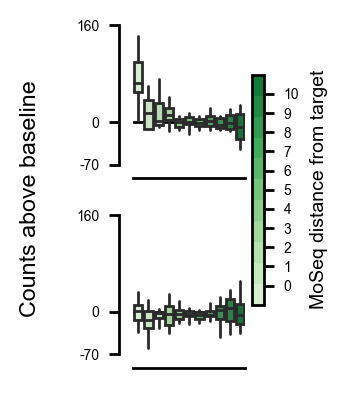

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(1.4, 2), sharex=True, sharey=True)

sns.boxplot(
    data=change_mu_all.xs(("ctrl"), level=("learner")).reset_index(),
    ax=ax[1],
    x="dist_bin",
    y="change_count",
    hue="dist_bin",
    showfliers=False,
    showcaps=False,
    palette=pal,
    dodge=False,
)
sns.boxplot(
    data=change_mu.xs(
        ("yes", "snc (axon)", False), level=("learner", "area", "censor")
    ).reset_index(),
    ax=ax[0],
    x="dist_bin",
    y="change_count",
    hue="dist_bin",
    showfliers=False,
    showcaps=False,
    palette=pal,
    dodge=False,
)

for _ax in ax:
    _ax.legend().remove()
    _ax.axhline(y=0, color=plt.rcParams["axes.edgecolor"], zorder=-200)
    _ax.set_xlabel("")
    _ax.set_xticks([])
    _ax.set_ylabel("")

sns.despine(offset=5)
clean_ticks(ax[0], "y", precision=-1, dtype=int, zero_symmetry=False)
fig.supylabel("Counts above baseline")
fig.tight_layout()

cb = fig.colorbar(
    sm,
    ax=ax,
    shrink=0.7,
    pad=0.05,
    ticks=np.linspace(0, 1, ndist_bins),
    label="MoSeq distance from target",
)
cb.set_ticklabels(list(range(ndist_bins)))
savefig(
    fig,
    os.path.join(figure_cfg["store_dir"], "reinforcement_beh_dist_censor_obligates"),
    bbox_inches="tight",
)

In [42]:
from scipy.stats import mannwhitneyu, ttest_ind

In [43]:
from sklearn.utils import resample

In [44]:
bins = change_mu.index.get_level_values("dist_bin").unique()

In [45]:
use_test = mannwhitneyu

In [46]:
stats = {}
all_pvals = []
for _bin in range(len(bins)):
    dat1 = change_mu.xs((_bin, "yes", False), level=("dist_bin", "learner", "censor"))[
        "change_count"
    ]
    dat2 = change_mu_all.xs((_bin, "ctrl"), level=("dist_bin", "learner"))[
        "change_count"
    ]
    stat, pvalue = mannwhitneyu(dat1, dat2)
    stats[_bin] = {}
    stats[_bin]["p"] = pvalue
    stats[_bin]["f"] = stat / (len(dat1) * len(dat2))

    stats[_bin]["stat"] = stat
    stats[_bin]["n1"] = len(dat1)
    stats[_bin]["n2"] = len(dat2)

In [47]:
from statsmodels.stats.multitest import multipletests

corrected_pvals = multipletests([v["p"] for v in stats.values()], method="holm")[1]

In [49]:
for (k, v), new_pval in zip(stats.items(), corrected_pvals):
    v["p"] = new_pval

In [50]:
stats["n_definition"] = "average learning per mouse"
stats["test"] = str(use_test.__name__)

In [52]:
import json

In [53]:
with open(
    os.path.join(proc_dirs["closed_loop_behavior"], "stats_similar_v_dissimilar.toml"),
    "w",
) as f:
    toml.dump(json.loads(json.dumps(stats)), f)